In [1]:
!python --version

Python 3.10.13


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as ks
import struct
from array import array
from os.path  import join
%matplotlib inline
import random
import matplotlib.pyplot as plt
import os
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score, classification_report
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_curve
import seaborn as sns
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [3]:
tf.__version__

'2.14.0'

In [4]:
ks.__version__

'2.14.0'

In [5]:
# MNIST Data Loader Class

class MnistDataloader:
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

In [6]:
def plot_random_samples(n_samples: int=9, width: int=10, height: int=10)->None:
    n_samples=1 if n_samples<1 else n_samples
    remainder=n_samples%3
    n_rows=np.ceil(n_samples/3).astype(int) if n_samples > 3 else 1
    n_cols=3 if n_samples >= 3 else n_samples
    print(f'No of columns: {n_cols} | No. of rows: {n_rows} | No. of samples: {n_samples}'.center(os.get_terminal_size().columns))

    fig = plt.figure(figsize=(width, height))
    # ax enables access to manipulate each of subplots
    ax = []

    for i in range(n_samples):
        img_no = np.random.randint(0, len(X))
        img_label = Y[img_no]
        img_label = 0 if int(img_label) == 10 else img_label
        img = X[img_no]
        # create subplot and append to ax
        ax.append(fig.add_subplot(n_rows, n_cols, i+1))
        # set title
        ax[-1].set_title(img_label)
        ax[-1].axis('off')
        fig.tight_layout()
        plt.imshow(img, cmap='gray')
    plt.show();

In [7]:
def plot_random_predictions(model, n_samples: int=9, width: int=10, height: int=10)->None:
    n_samples=1 if n_samples<1 else n_samples
    remainder=n_samples%3
    n_rows=np.ceil(n_samples/3).astype(int) if n_samples > 3 else 1
    n_cols=3 if n_samples >= 3 else n_samples
    print(f'No of columns: {n_cols} | No. of rows: {n_rows} | No. of samples: {n_samples}'.center(os.get_terminal_size().columns))

    fig = plt.figure(figsize=(width, height))
    # ax enables access to manipulate each of subplots
    ax = []

    for i in range(n_samples):
        img_no = np.random.randint(0, len(X))
        img_label = Y[img_no]
        img = X[img_no]
        prediction = model.predict(np.expand_dims(img, axis=0), verbose=0)
        predicted_label = np.argmax(prediction > 0.5)
        prediction_percentage = np.round(prediction[0][predicted_label]*100, 2)
        # create subplot and append to ax
        ax.append(fig.add_subplot(n_rows, n_cols, i+1))
        # set title
        ax[-1].set_title(f'Predicted: {predicted_label} | {prediction_percentage}%\nTrue: {img_label}', fontsize=9, color="green" if img_label==predicted_label else "red")
        ax[-1].axis('off')
        fig.tight_layout()
        plt.imshow(img, cmap='gray')
    plt.show();

In [8]:
def plot_auc_scores(clf, X_test, y_test, Y):
    y_test_bin = label_binarize(y_test, classes=np.unique(Y).tolist())
    n_classes = y_test_bin.shape[1]
    y_score = clf.predict(X_test)
    
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc="lower right")
    plt.show()

In [9]:
def normalize_images(X):
    return X/255

In [10]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest, y):
    encoder = np.unique(y)
    
    visualizer = ROCAUC(model, encoder=encoder, size=(1080, 720))
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

In [11]:
input_path = './'
training_images_filepath = join(input_path, './train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, './train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, './t10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, './t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

In [12]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

In [13]:
X = np.concatenate((np.array(x_train),np.array(x_test)))
Y = np.concatenate((np.array(y_train),np.array(y_test)))
X = normalize_images(X)

                                 No of columns: 3 | No. of rows: 3 | No. of samples: 9                                  


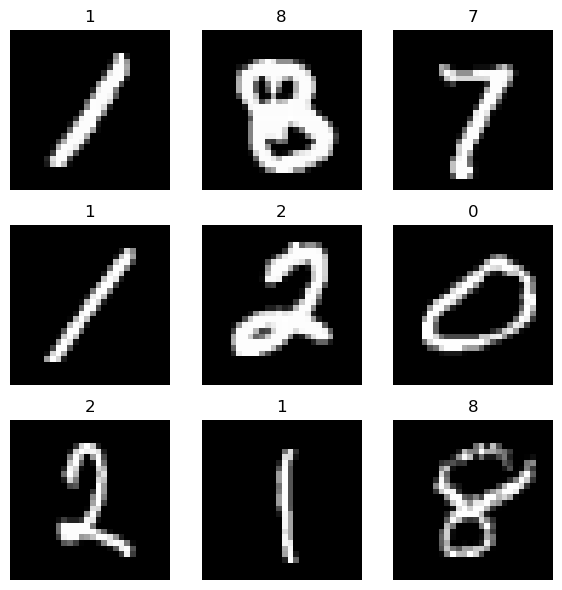

In [14]:
plot_random_samples(n_samples=9, width=6, height=6)

In [15]:
IMG_SIZE = np.array(X[0]).shape
print('Image size: ', IMG_SIZE)

Image size:  (28, 28)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0, shuffle=True)

In [17]:
# Initialising the CNN
NO_NEURONS = 128


clf = tf.keras.models.Sequential()
# CONVOLUTION LAYER
clf.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)))
# POOLING LAYER
clf.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# 2ND CONVOLUTION LAYER
clf.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
clf.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# FLATTENING LAYER
clf.add(tf.keras.layers.Flatten())
# FULLY CONNECTED LAYER
clf.add(Dropout(0.2))
clf.add(tf.keras.layers.Dense(units=NO_NEURONS, activation='relu'))
# OUTPUT LAYER
clf.add(tf.keras.layers.Dense(units=len(np.unique(Y)), activation='softmax'))

clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dropout (Dropout)           (None, 800)               0

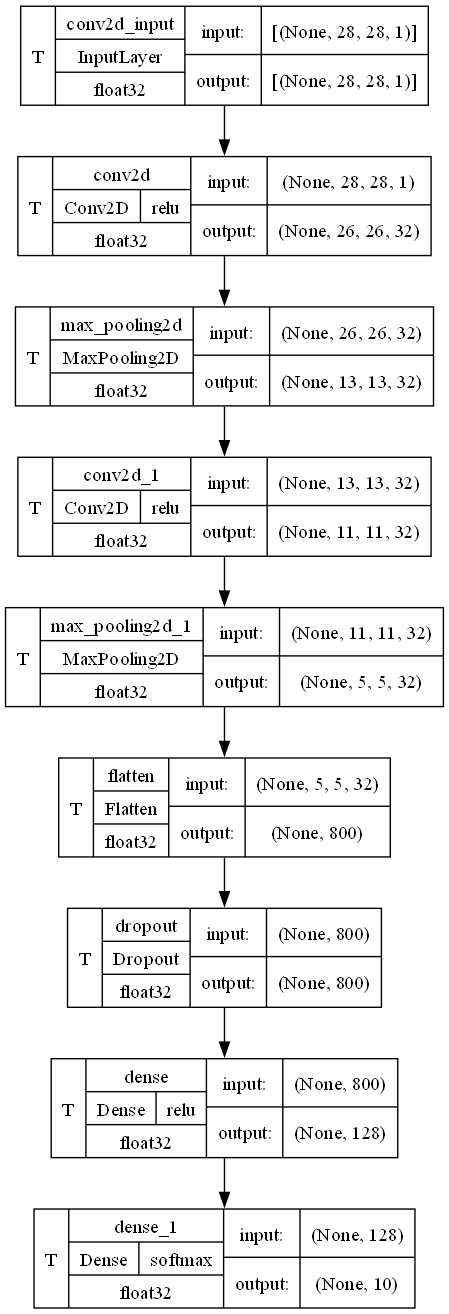

In [18]:
ks.utils.plot_model(
    clf,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
    show_layer_activations=True,
    show_trainable=True,
)

In [19]:
clf.compile(optimizer = ks.optimizers.Adam(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy', metrics='accuracy')

In [20]:
history = clf.fit(X_train, y_train, epochs = 10, batch_size = 1, validation_data=(X_test, y_test))

Epoch 1/10
56000/56000 [==============================] - 79s 1ms/step - loss: 0.1855 - accuracy: 0.9429 - val_loss: 0.0695 - val_accuracy: 0.9777
Epoch 2/10
56000/56000 [==============================] - 79s 1ms/step - loss: 0.0624 - accuracy: 0.9801 - val_loss: 0.0514 - val_accuracy: 0.9824
Epoch 3/10
56000/56000 [==============================] - 79s 1ms/step - loss: 0.0451 - accuracy: 0.9861 - val_loss: 0.0447 - val_accuracy: 0.9851
Epoch 4/10
56000/56000 [==============================] - 79s 1ms/step - loss: 0.0363 - accuracy: 0.9886 - val_loss: 0.0349 - val_accuracy: 0.9893
Epoch 5/10
56000/56000 [==============================] - 78s 1ms/step - loss: 0.0297 - accuracy: 0.9906 - val_loss: 0.0382 - val_accuracy: 0.9886
Epoch 6/10
56000/56000 [==============================] - 79s 1ms/step - loss: 0.0258 - accuracy: 0.9919 - val_loss: 0.0326 - val_accuracy: 0.9906
Epoch 7/10
56000/56000 [==============================] - 78s 1ms/step - loss: 0.0226 - accuracy: 0.9929 - val_loss: 0

438/438 [==============================] - 1s 2ms/step
Accuracy:  99.2
[[1380    0    1    0    1    0    3    1    0    1]
 [   0 1571    1    1    0    0    2    4    0    1]
 [   1    1 1434    0    0    0    0    3    2    2]
 [   1    0    2 1428    0    1    0    1    1    1]
 [   0    1    1    0 1338    0    2    2    0    6]
 [   2    0    2    6    1 1212    7    0    0    1]
 [   1    0    0    0    2    1 1382    0    0    1]
 [   1    4    6    0    2    0    0 1443    0    2]
 [   2    1    1    0    1    0    2    1 1354    6]
 [   4    0    0    1    7    0    0    2    1 1346]]


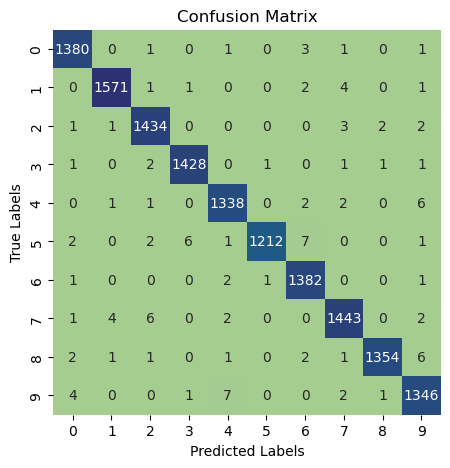

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1387
           1       1.00      0.99      0.99      1580
           2       0.99      0.99      0.99      1443
           3       0.99      1.00      0.99      1435
           4       0.99      0.99      0.99      1350
           5       1.00      0.98      0.99      1231
           6       0.99      1.00      0.99      1387
           7       0.99      0.99      0.99      1458
           8       1.00      0.99      0.99      1368
           9       0.98      0.99      0.99      1361

    accuracy                           0.99     14000
   macro avg       0.99      0.99      0.99     14000
weighted avg       0.99      0.99      0.99     14000



In [21]:
y_pred = clf.predict(X_test)
y_pred = np.argmax((y_pred > 0.5), axis=1)


print('Accuracy: ', accuracy_score(y_test, y_pred)*100)

cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show();


print(classification_report(y_test, y_pred))

438/438 [==============================] - 1s 2ms/step


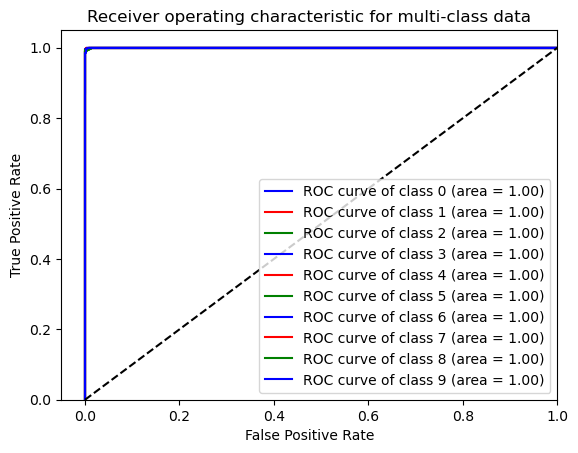

In [22]:
plot_auc_scores(clf, X_test, y_test, Y)

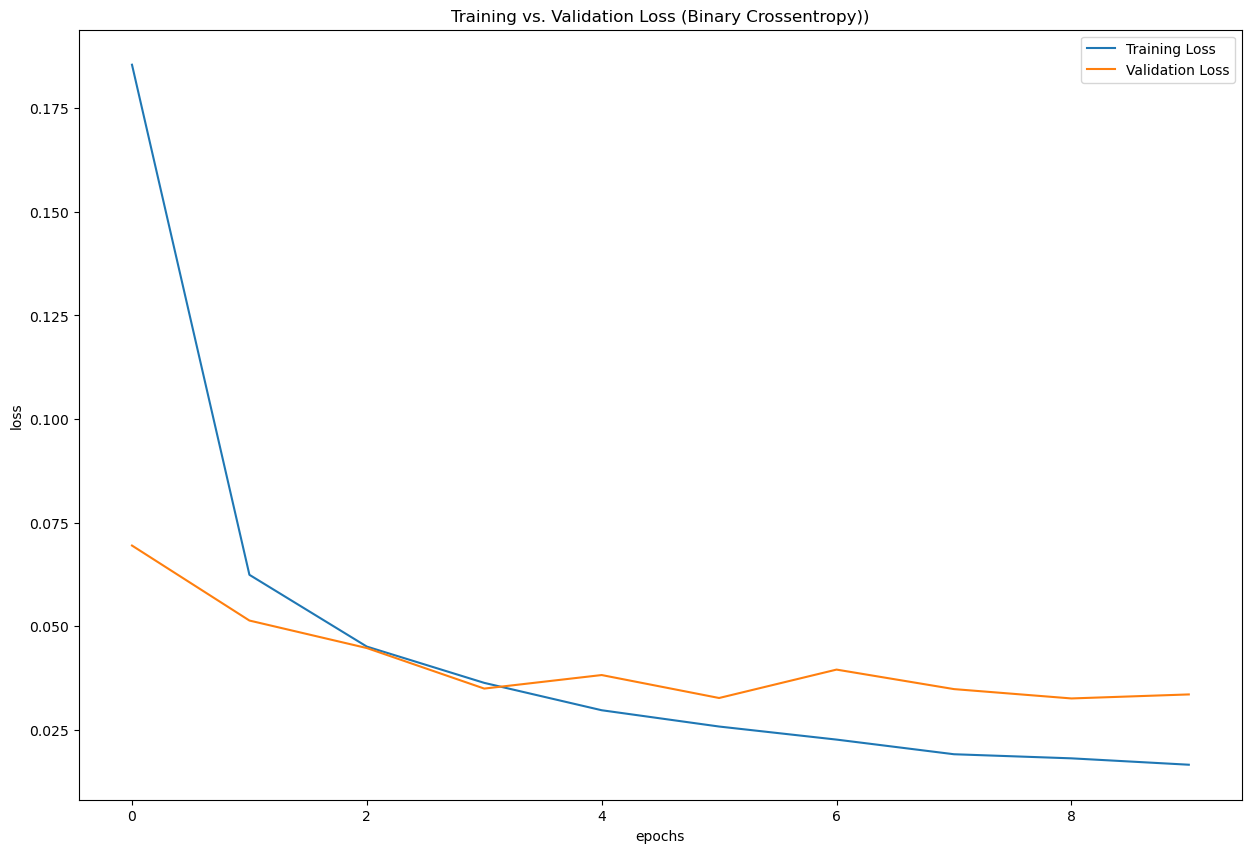

In [23]:
plt.figure(figsize=(15,10))
plt.plot(history.history[list(history.history.keys())[0]],label='Training Loss')
plt.plot(history.history[list(history.history.keys())[2]],label='Validation Loss')
plt.title(f'Training vs. Validation Loss (Binary Crossentropy))')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Max Train accuracy:  0.9948035478591919  | Max Val accuracy:  0.9922142624855042


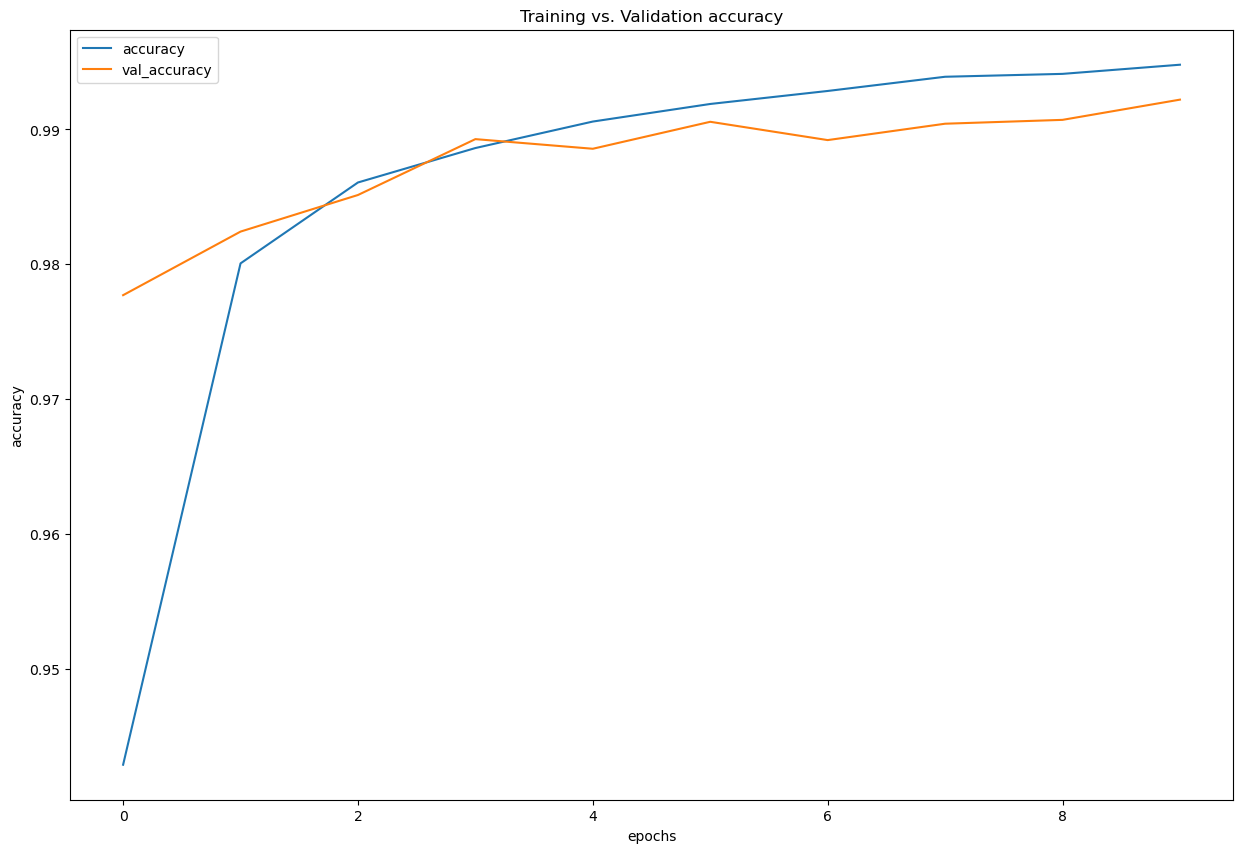

In [24]:
print(f'Max Train {list(history.history.keys())[1]}: ', max(history.history[list(history.history.keys())[1]]), f' | Max Val {list(history.history.keys())[1]}: ', max(history.history[list(history.history.keys())[-1]]))

plt.figure(figsize=(15,10))
plt.plot(history.history[list(history.history.keys())[1]],label=f'{list(history.history.keys())[1]}')
plt.plot(history.history[list(history.history.keys())[-1]],label=f'{list(history.history.keys())[-1]}')
plt.title(f'Training vs. Validation {list(history.history.keys())[1]}')
plt.xlabel('epochs')
plt.ylabel(f'{list(history.history.keys())[1]}')
# plt.ylim(0, 1)
plt.legend()
plt.show()

                                 No of columns: 3 | No. of rows: 5 | No. of samples: 15                                 


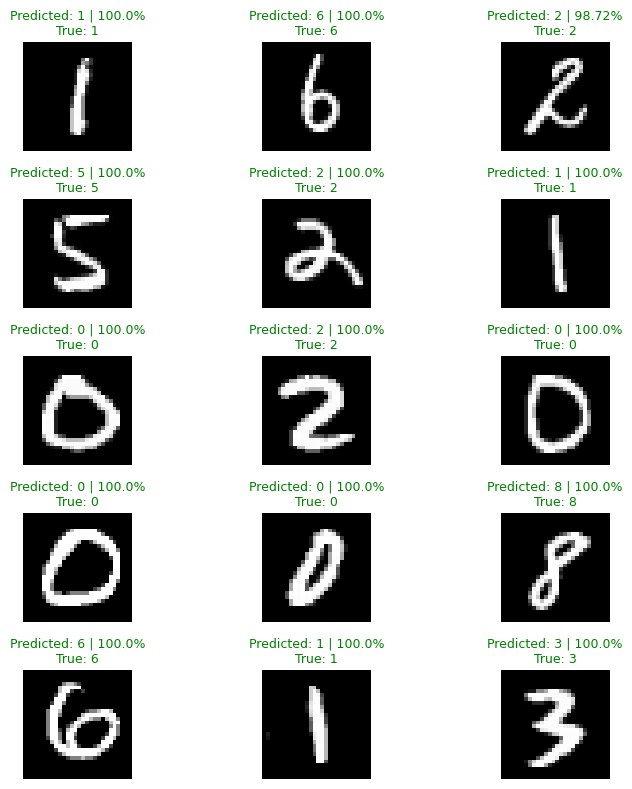

In [25]:
plot_random_predictions(model=clf, n_samples=15, width=8, height=8)

In [26]:
test_img = ks.utils.load_img('./test.jpg', color_mode='grayscale')
test_img_arr = ks.utils.img_to_array(test_img)
test_img_arr.shape

(1368, 1632, 1)

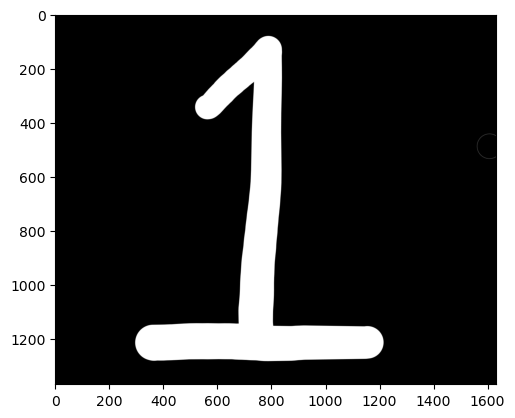

In [27]:
plt.imshow(test_img_arr, cmap='gray')

In [28]:
test_img_arr = tf.keras.preprocessing.image.smart_resize(test_img_arr, IMG_SIZE)
test_img_arr.shape

(28, 28, 1)

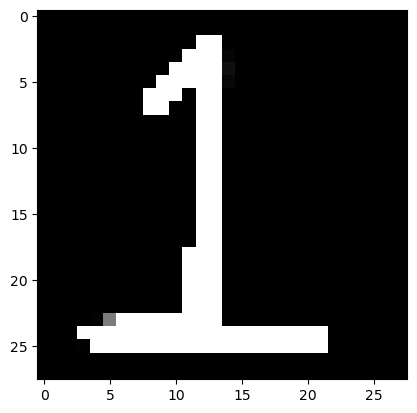

In [29]:
plt.imshow(test_img_arr, cmap='gray')

In [30]:
prediction = np.argmax(clf.predict(np.expand_dims(test_img_arr, axis=0), verbose=0) > 0.5)
prediction

1